Found SDF files:
  1. all_molecules.sdf

Using file: all_molecules.sdf
Successfully read 16 molecules for testing

ANALYZING PROBLEM MOLECULES
Analyzing problem molecules from: all_molecules.sdf

ANALYZING Molecule_1:
SMILES: [H]OC1=C([H])C([H])=C(/C([H])=C(/[H])C([H])([H])O[C@]2([H])C(=O)[C@]([H])(C([H])([H])[H])[C@]3([H])C([H])([H])C(=O)O[C@]4(C([H])([H])[H])C([H])([H])[C@@]5([H])[C@]([H])(C([H])([H])[H])C([H])([H])[C@]([H])(C([H])([H])[H])C(=O)[C@]5(C([H])([H])[H])[C@]2([H])[C@@]43C([H])([H])[H])C([H])=C1[H]
Molecular formula: C31H40O6
Molecular weight: 508.28
Number of atoms: 77
Number of heavy atoms: 37
Atoms present: C, H, O
✓ Can generate 3D coordinates
✓ MMFF94 parameters available

ANALYZING Molecule_5:
SMILES: CC(C)CC(=O)O[C@H]1C(=O)O[C@H]2C[C@@H]3[C@@H](C)CC(=O)C(=O)[C@]3(C)[C@H]3[C@]24CO[C@]3(O)C(=O)[C@H](C)[C@H]14
Molecular formula: C25H32O9
Molecular weight: 476.20
Number of atoms: 34
Number of heavy atoms: 34
Atoms present: C, O
✓ Can generate 3D coordinates
✓ MMFF94 par

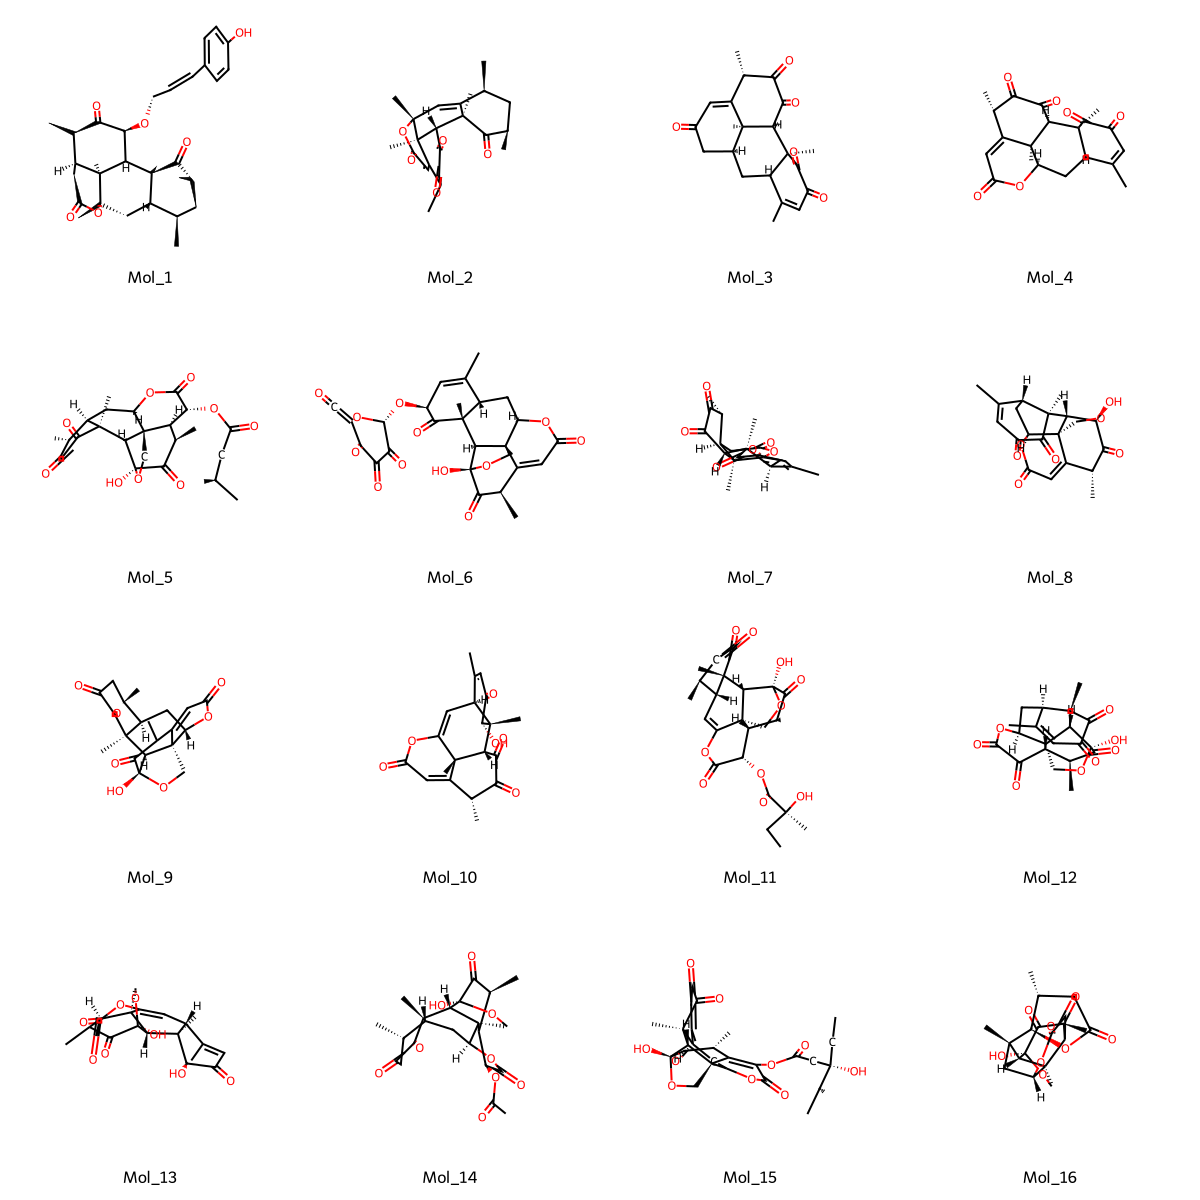

In [14]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
import os
from IPython.display import display

# Set working directory to desktop
desktop_path = r"C:\Users\Usuario X\Desktop"
os.chdir(desktop_path)

def safe_get_prop(mol, prop_name, default):
    """Safely get property from molecule, handling encoding issues"""
    try:
        if mol.HasProp(prop_name):
            prop_value = mol.GetProp(prop_name)
            # Try to decode if it's bytes, otherwise return as is
            if isinstance(prop_value, bytes):
                return prop_value.decode('latin1', errors='ignore')
            return prop_value
        return default
    except:
        return default

def read_sdf_with_encoding(sdf_file, sanitize=False):
    """Read SDF file with proper encoding handling"""
    try:
        # First try standard reading
        supplier = Chem.SDMolSupplier(sdf_file, sanitize=sanitize, removeHs=False)
        mols = [mol for mol in supplier if mol is not None]
        return mols
    except UnicodeDecodeError:
        print("Unicode error detected, trying alternative encoding...")
        try:
            # Try with different encoding by reading file manually
            with open(sdf_file, 'rb') as f:
                content = f.read()
            
            # Try Latin-1 encoding (handles all byte values)
            content_decoded = content.decode('latin1')
            
            # Write to temporary file
            temp_file = "temp_encoded.sdf"
            with open(temp_file, 'w', encoding='utf-8') as f:
                f.write(content_decoded)
            
            # Read temporary file
            supplier = Chem.SDMolSupplier(temp_file, sanitize=sanitize, removeHs=False)
            mols = [mol for mol in supplier if mol is not None]
            
            # Clean up
            if os.path.exists(temp_file):
                os.remove(temp_file)
            
            return mols
        except Exception as e:
            print(f"Alternative encoding also failed: {e}")
            return []

def robust_energy_minimization(sdf_file, output_sdf="minimized_molecules.sdf", max_molecules=16):
    """
    Robust energy minimization with multiple fallback methods.
    """
    
    print(f"Reading molecules from: {sdf_file}")
    
    # Read molecules from SDF with encoding handling
    molecules = read_sdf_with_encoding(sdf_file, sanitize=False)
    
    if not molecules:
        print("No molecules could be read from the file!")
        return []
    
    # Limit to max_molecules
    molecules = molecules[:max_molecules]
    
    print(f"Processing {len(molecules)} molecules for energy minimization...")
    
    minimized_molecules = []
    failure_reasons = {}
    
    for i, mol in enumerate(molecules):
        # Use safe property getter for molecule name
        mol_name = safe_get_prop(mol, "_Name", f"Molecule_{i+1}")
        print(f"\nProcessing {mol_name}...")
        
        try:
            # Sanitize the molecule if needed
            try:
                Chem.SanitizeMol(mol)
            except:
                print("  ⚠ Sanitization failed, proceeding without...")
            
            # Create a copy to preserve original
            mol_copy = Chem.Mol(mol)
            
            # Add hydrogens for more accurate minimization
            mol_copy = Chem.AddHs(mol_copy)
            
            # Generate 3D coordinates if not present
            if mol_copy.GetNumConformers() == 0:
                embed_result = AllChem.EmbedMolecule(mol_copy, randomSeed=42)
                if embed_result == -1:
                    print("  ✗ Cannot generate 3D coordinates")
                    minimized_molecules.append(mol)
                    failure_reasons[mol_name] = "Cannot generate 3D coordinates"
                    continue
                else:
                    print(f"  Generated 3D coordinates")
            
            # METHOD 1: Try MMFF94 first (most accurate for organic molecules)
            try:
                result = AllChem.MMFFOptimizeMolecule(mol_copy, maxIters=500)
                if result == 0:
                    print(f"  ✓ MMFF94 minimization successful")
                    minimized_molecules.append(Chem.RemoveHs(mol_copy))
                    continue
                else:
                    print(f"  ✗ MMFF94 failed with code {result}")
            except Exception as e:
                print(f"  ✗ MMFF94 error: {str(e)[:50]}...")
            
            # METHOD 2: Try UFF (Universal Force Field - more general)
            try:
                mol_uff = Chem.Mol(mol)  # Fresh copy from original
                mol_uff = Chem.AddHs(mol_uff)
                if mol_uff.GetNumConformers() == 0:
                    AllChem.EmbedMolecule(mol_uff, randomSeed=42)
                
                uff_result = AllChem.UFFOptimizeMolecule(mol_uff, maxIters=500)
                if uff_result == 0:
                    print(f"  ✓ UFF minimization successful")
                    minimized_molecules.append(Chem.RemoveHs(mol_uff))
                    continue
                else:
                    print(f"  ✗ UFF failed with code {uff_result}")
            except Exception as e:
                print(f"  ✗ UFF error: {str(e)[:50]}...")
            
            # METHOD 3: Simple ETKDG conformation (no force field)
            try:
                mol_etkdg = Chem.Mol(mol)
                mol_etkdg = Chem.AddHs(mol_etkdg)
                embed_result = AllChem.EmbedMolecule(mol_etkdg, randomSeed=42)
                if embed_result == 0:
                    print(f"  ✓ Using ETKDG coordinates (no force field)")
                    minimized_molecules.append(Chem.RemoveHs(mol_etkdg))
                    continue
                else:
                    print(f"  ✗ ETKDG embedding failed")
            except Exception as e:
                print(f"  ✗ ETKDG also failed: {str(e)[:50]}...")
            
            # If all methods fail, keep original
            print(f"  ⚠ All minimization methods failed, keeping original structure")
            minimized_molecules.append(mol)
            failure_reasons[mol_name] = "All methods failed"
            
        except Exception as e:
            print(f"  💥 Critical error: {e}")
            # Keep original molecule as fallback
            minimized_molecules.append(mol)
            failure_reasons[mol_name] = f"Critical error: {e}"
    
    # Print summary
    print(f"\n" + "="*60)
    print("MINIMIZATION SUMMARY")
    print("="*60)
    print(f"Total molecules processed: {len(molecules)}")
    print(f"Successfully minimized: {len([m for m in minimized_molecules if m is not None])}")
    
    if failure_reasons:
        print(f"Molecules with issues: {len(failure_reasons)}")
        for mol_name, reason in failure_reasons.items():
            print(f"  {mol_name}: {reason}")
    
    # Save minimized molecules to new SDF file
    if minimized_molecules:
        writer = Chem.SDWriter(output_sdf)
        for mol in minimized_molecules:
            if mol is not None:
                writer.write(mol)
        writer.close()
        print(f"\nMinimized structures saved to: {output_sdf}")
    
    return minimized_molecules

def analyze_problem_molecules(sdf_file, problem_indices=[1, 5, 15]):
    """
    Analyze specific molecules that are causing problems.
    """
    print(f"Analyzing problem molecules from: {sdf_file}")
    
    molecules = read_sdf_with_encoding(sdf_file, sanitize=False)
    
    if not molecules:
        print("No molecules could be read from the file!")
        return
    
    for idx in problem_indices:
        if idx <= len(molecules):
            mol = molecules[idx-1]  # Convert to 0-based index
            # Use safe property getter for molecule name
            mol_name = safe_get_prop(mol, "_Name", f"Molecule_{idx}")
            
            print(f"\n" + "="*40)
            print(f"ANALYZING {mol_name}:")
            print("="*40)
            
            # Basic molecule info
            try:
                print(f"SMILES: {Chem.MolToSmiles(mol)}")
                print(f"Molecular formula: {rdMolDescriptors.CalcMolFormula(mol)}")
                print(f"Molecular weight: {rdMolDescriptors.CalcExactMolWt(mol):.2f}")
                print(f"Number of atoms: {mol.GetNumAtoms()}")
                print(f"Number of heavy atoms: {mol.GetNumHeavyAtoms()}")
                
                # Check for unusual atoms
                atoms = set()
                for atom in mol.GetAtoms():
                    atoms.add(atom.GetSymbol())
                
                print(f"Atoms present: {', '.join(sorted(atoms))}")
                
                # Check for common problematic features
                common_atoms = ['C', 'H', 'N', 'O', 'P', 'S', 'F', 'Cl', 'Br', 'I']
                if any(atom.GetSymbol() not in common_atoms for atom in mol.GetAtoms()):
                    print("⚠ Contains unusual atoms that might not be in force field")
                
                # Try to identify the issue
                mol_h = Chem.AddHs(mol)
                try:
                    # Check if we can generate coordinates
                    embed_result = AllChem.EmbedMolecule(mol_h, randomSeed=42)
                    if embed_result == -1:
                        print("⚠ Cannot generate 3D coordinates")
                    else:
                        print("✓ Can generate 3D coordinates")
                        
                        # Check MMFF parameters
                        mmff_props = AllChem.MMFFGetMoleculeProperties(mol_h)
                        if mmff_props is None:
                            print("⚠ MMFF94 parameters cannot be initialized")
                        else:
                            print("✓ MMFF94 parameters available")
                            
                except Exception as e:
                    print(f"⚠ 3D analysis error: {e}")
                    
            except Exception as e:
                print(f"⚠ Basic analysis error: {e}")

# Main execution
if __name__ == "__main__":
    # Find SDF files on desktop
    sdf_files = [f for f in os.listdir() if f.lower().endswith('.sdf')]
    
    if sdf_files:
        print("Found SDF files:")
        for i, file in enumerate(sdf_files):
            print(f"  {i+1}. {file}")
        
        # Use the first SDF file found
        input_file = sdf_files[0]
        print(f"\nUsing file: {input_file}")
        
        # Test file reading first
        test_mols = read_sdf_with_encoding(input_file, sanitize=False)
        if not test_mols:
            print("ERROR: Cannot read the SDF file. The file may be corrupted or use an unsupported encoding.")
        else:
            print(f"Successfully read {len(test_mols)} molecules for testing")
            
            # Analyze problem molecules first
            print("\n" + "="*50)
            print("ANALYZING PROBLEM MOLECULES")
            print("="*50)
            analyze_problem_molecules(input_file, [1, 5, 15])
            
            # Perform robust minimization
            print("\n" + "="*50)
            print("PERFORMING ROBUST ENERGY MINIMIZATION")
            print("="*50)
            minimized_mols = robust_energy_minimization(input_file)
            
            # Display results
            if minimized_mols:
                print("\n" + "="*50)
                print("DISPLAYING MINIMIZED MOLECULES")
                print("="*50)
                
                legends = []
                for i, mol in enumerate(minimized_mols):
                    # Use safe property getter for legends too
                    mol_name = safe_get_prop(mol, "_Name", f"Mol_{i+1}")
                    legends.append(mol_name)
                
                img = Draw.MolsToGridImage(
                    minimized_mols, 
                    molsPerRow=4, 
                    subImgSize=(300, 300),
                    legends=legends
                )
                display(img)
            else:
                print("No minimized molecules to display")
        
    else:
        print("No SDF files found on desktop.")